# 7.1 Impact of text filtering

Import helper functions

In [1]:
from pa_utils import *

Load development set with image ids and labels

In [2]:
dev = read_data("dev_seen")

Load dataset where each row contains information about particular object

In [3]:
dev_objects = read_objects(dev)

In [4]:
dev_objects.head()

,object_id,object_conf,image_id,x1,y1,x2,y2
0,51,0.856069,8291,507.415405,255.599075,781.199463,523.992737
1,51,0.850566,8291,235.439621,235.486084,475.613678,521.027527
2,226,0.793131,8291,471.342255,73.475983,781.282593,548.000000
3,119,0.851232,8291,605.618958,82.541481,747.604431,188.575043
4,47,0.818660,8291,484.101929,483.987579,719.916260,548.000000


Count bounding boxes around text for each image

In [5]:
is_object_text = dev_objects["object_id"]==1179
dev_num_text_img = dev_objects[is_object_text].groupby(by="image_id")["object_id"].count().reset_index()
dev_num_text_img = dev_num_text_img.rename(columns={"image_id": "id", "object_id":"num_text_bboxes"})

Load predictions of the baseline and the text filtering modification and merge them

In [6]:
base_dev_preds = pd.read_csv(f"../model_checkpoints/lucky-frost-115/meme_dev_seen_preds.csv")
text_filter_dev_preds = pd.read_csv(f"../model_checkpoints/skilled-fog-122/meme_dev_seen_preds.csv")

In [7]:
dev_preds = pd.merge(base_dev_preds, text_filter_dev_preds[["id", "proba"]], on="id", suffixes=["_base", "_tf"])
dev_preds = dev_preds[["id", "gt", "proba_base", "proba_tf"]]

To each image, assign text bounding box count. Null values indicate images with no text bounding boxes, so replace with 0.

In [8]:
dev_preds = pd.merge(dev_preds, dev_num_text_img, on="id", how = "left").fillna(0)

We want to use a metric that is positive when the probability of an example become closer to the ground truth label i.e. closer to 1 for a positive example and closer to 0 for a negative example. Thus we calculate loss for each example based on the base probability and the text filtering probability. Finally, we take their difference to obtain the final score.

In [9]:
def bce_loss(ground_truth, predict_proba):
    return ground_truth * np.log(predict_proba) + (1 - ground_truth) * np.log(1 - predict_proba)

Compute loss difference

In [10]:
dev_preds["base loss"] = bce_loss(dev_preds["gt"], dev_preds["proba_base"])
dev_preds["tf loss"] = bce_loss(dev_preds["gt"], dev_preds["proba_tf"])
dev_preds["loss diff"] = dev_preds["tf loss"] - dev_preds["base loss"]

Compute pearson correlation and plot

In [11]:
from scipy.stats import pearsonr
pearsonr(dev_preds["loss diff"], dev_preds["num_text_bboxes"])

(-0.09663099313091714, 0.030742919712012446)

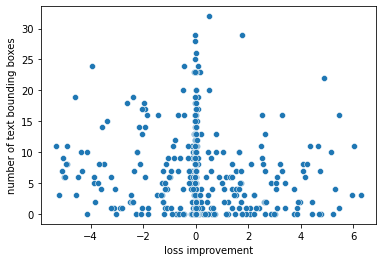

In [12]:
import seaborn as sns
sns.scatterplot(x="loss diff", y="num_text_bboxes", data=dev_preds)
plt.ylabel("number of text bounding boxes")
plt.xlabel("loss improvement")
# plt.title("Correlation between number of text bounding boxes \n and loss improvement from baseline to text filtering results")
plt.show()